## A Fantasy Premier League (FPL) Points Predictor using Linear Regression

The data set used for this prediction model has been scraped and shared at the following link:
https://github.com/vaastav/Fantasy-Premier-League

The github repo contains data for every gameweek since the 2016/17 season. The first model will be trained on data from the latest full season (2019-2020).

The aim of this notebook is to predict the amount of points a footballer will score in the next gameweek.

#### Initial assumption
Form matters - how a footballer performs one week will effect his performance the week after

#### Import packages

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', None)


import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

### 1. Load data

In [42]:
weekly_data = {}
for week in range(1,48):
    try:
        data = pd.read_csv(f"../Fantasy-Premier-League-master/data/2019-20/gws/gw{week}.csv")
        weekly_data[week] = data
    except:
        pass

In [43]:
for wk in weekly_data: 
    if wk == 47: 
        pass 
    else: 
        df = pd.merge(weekly_data[wk], weekly_data[wk+1][['name', 'total_points']], on='name', how='inner')  
        home_dummy = pd.get_dummies(df['was_home'], prefix='home') 
        df = pd.concat([df, home_dummy], axis=1).drop(['was_home', 'kickoff_time'], axis=1) # dropping kickoff time 
        weekly_engineered[wk] = df

In [44]:
full_df = pd.concat([x[1] for x in list(weekly_engineered.items())], axis=0).reset_index(drop=True)

In [45]:
full_df.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points_x,transfers_balance,transfers_in,transfers_out,value,yellow_cards,total_points_y,home_False,home_True
0,Aaron_Cresswell_376,0,0,7,0,1.5,376,8,5,0,1.1,9.0,90,11,0,0,0,0,1,0,23399,5,0,0.0,0,0,0,0,50,0,0,0.0,1.0
1,Aaron_Lennon_430,0,0,3,0,0.0,430,3,0,0,0.2,2.0,6,16,0,0,0,0,1,0,8105,0,3,0.0,1,0,0,0,50,0,1,0.0,1.0
2,Aaron_Mooy_516,0,0,0,0,0.0,516,7,0,0,0.0,0.0,0,18,0,0,0,0,1,0,16261,3,0,0.0,0,0,0,0,50,0,1,1.0,0.0
3,Aaron_Ramsdale_494,0,0,11,0,0.0,494,2,1,0,1.0,9.8,90,15,0,0,0,0,1,2,3091,1,1,0.0,2,0,0,0,45,0,4,0.0,1.0
4,Aaron_Wan-Bissaka_122,0,2,34,1,16.1,122,9,0,0,4.9,30.4,90,6,0,0,0,0,1,0,1879259,0,4,2.0,8,0,0,0,55,0,1,0.0,1.0


In [46]:
full_df.tail()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points_x,transfers_balance,transfers_in,transfers_out,value,yellow_cards,total_points_y,home_False,home_True
21087,Youri_Tielemans_448,0,0,16,0,52.5,448,368,3,0,7.0,13.0,69,17,0,0,0,0,46,0,287164,0,3,4.0,2,-897,2115,3012,61,0,2,1.0,0.0
21088,Yves_Bissouma_53,0,0,12,1,3.1,53,363,0,0,1.2,9.0,72,13,0,0,0,0,46,0,2017,0,0,0.0,2,35,78,43,50,1,7,0.0,1.0
21089,Zech_Medley_636,0,0,0,0,0.0,636,361,0,0,0.0,0.0,0,2,0,0,0,0,46,0,2105,0,1,0.0,0,49,172,123,40,0,0,1.0,0.0
21090,Çaglar_Söyüncü_164,0,0,0,0,0.0,164,368,0,0,0.0,0.0,0,17,0,0,0,0,46,0,786864,0,3,0.0,0,-152350,242,152592,49,0,0,1.0,0.0
21091,Ørjan_Nyland_27,0,0,0,0,0.0,27,361,0,0,0.0,0.0,0,1,0,0,0,0,46,0,28703,0,1,0.0,0,-1224,76,1300,43,0,0,0.0,1.0


Convert object data types to int or floats:

In [48]:
dtype_dict = full_df.dtypes.to_dict()
data = {}
for col in dtype_dict:
    if dtype_dict[col] == object:
        if col in ['name', 'opponent_team']:
            data[col] = full_df[col].values
        else:
            data[col] = [int(x) for x in full_df[col].values]
    else:
        # remaining data types are floats
        data[col] = full_df[col].values
        
data = pd.DataFrame(data)

In [50]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
assists,21092.0,0.040442,0.213181,0.0,0.0,0.0,0.00,3.0
bonus,21092.0,0.108430,0.491790,0.0,0.0,0.0,0.00,3.0
bps,21092.0,6.146691,9.713262,-12.0,0.0,0.0,11.00,90.0
clean_sheets,21092.0,0.104068,0.305356,0.0,0.0,0.0,0.00,1.0
creativity,21092.0,4.876579,10.858482,0.0,0.0,0.0,2.80,127.7
element,21092.0,297.658212,173.679814,1.0,148.0,295.0,445.00,668.0
fixture,21092.0,190.257491,107.351392,1.0,98.0,192.0,280.00,370.0
goals_conceded,21092.0,0.510051,0.959096,0.0,0.0,0.0,1.00,9.0
goals_scored,21092.0,0.044756,0.230621,0.0,0.0,0.0,0.00,4.0
ict_index,21092.0,1.790632,3.091287,0.0,0.0,0.0,2.60,35.8


In [51]:
print(f"{data.shape[0]} observations and {data.shape[1]} features")

21092 observations and 33 features


## 2. Exploratory Data Analysis

Quick correlation matrix with all features

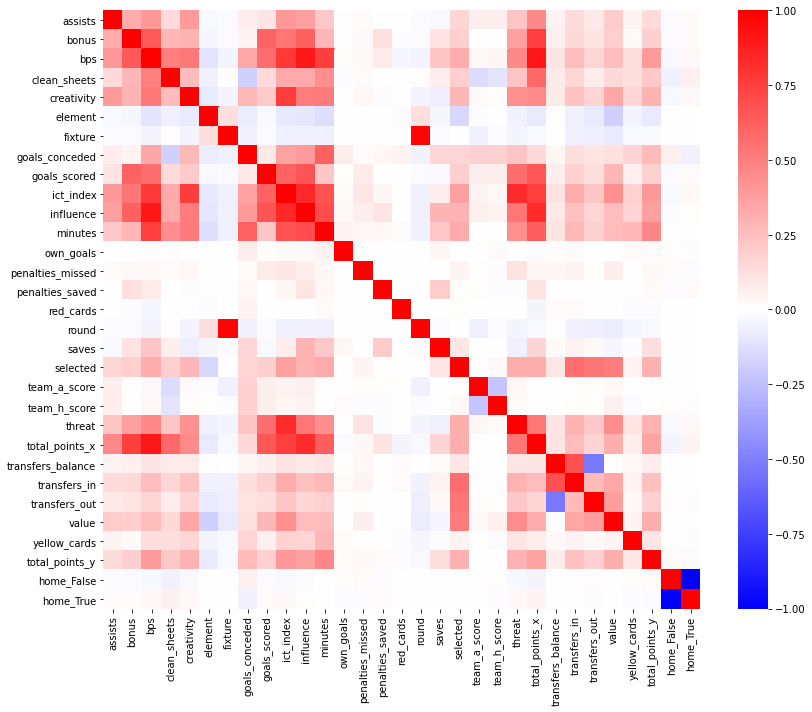

In [56]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=False, cmap='bwr')
plt.tight_layout()

In [113]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")

Let's find the top correlations for the target feature, total points next week (the variable called "total_points_y"):

In [60]:
top_corr = list(zip(data.corr()['total_points_y'].index, data.corr()['total_points_y'].values))
top_corr = sorted(top_corr, key=lambda x:abs(x[1]), reverse=True)

print("Top 5 Correlations with Total Points Scored Next Week")
print("-----------------------------------------------------\n")
for (feature, corr) in top_corr[1:6]:
    print(f"{feature} has correlation value of {corr}")

Top 5 Correlations with Total Points Scored Next Week
-----------------------------------------------------

minutes has correlation value of 0.4695364617009615
ict_index has correlation value of 0.40072286374335503
bps has correlation value of 0.3970822139054743
influence has correlation value of 0.37309079798108574
total_points_x has correlation value of 0.36480532290475237


We can see that the most correlated features with points earned in the following week are:
- minutes
- ict index (influence, creativity, threat index, a football statistical index developed specifically to assess a player as an FPL asset)
- bonus points
- influence
- total points in previous week

Now to plot some scatter plots to visualise these relationships:

In [63]:
from pylab import text

Text(0.5, 0.1, 'r = 0.37')

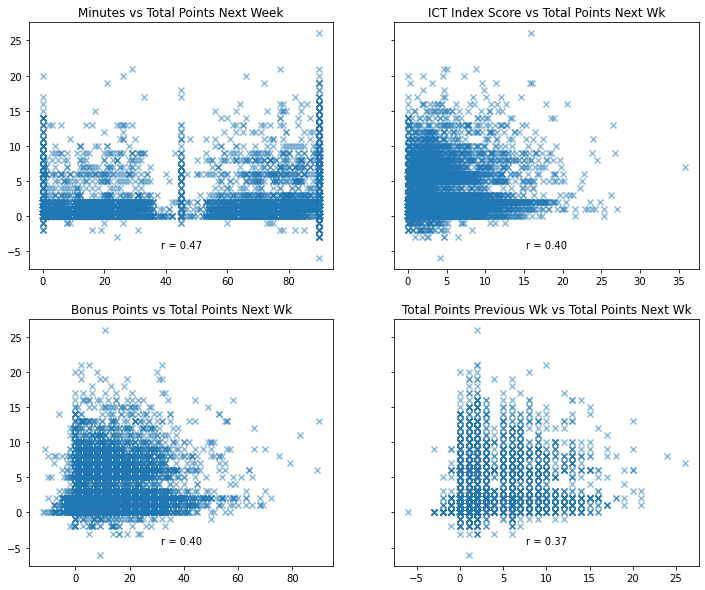

In [65]:
transparency = 0.5

fig, axs = plt.subplots(2,2, sharey=True, figsize=(12,10))
axs[0,0].scatter(data['minutes'].values, data['total_points_y'].values, alpha=transparency, marker='x')
axs[0,0].set_title('Minutes vs Total Points Next Week')
text(0.5, 0.1, 'r = 0.47', ha='center', va='center', transform=axs[0,0].transAxes)

axs[0,1].scatter(data['ict_index'].values, data['total_points_y'].values, alpha=transparency, marker='x')   
axs[0,1].set_title('ICT Index Score vs Total Points Next Wk')  
text(0.5, 0.1,'r = 0.40', ha='center', va='center', transform=axs[0,1].transAxes)

axs[1,0].scatter(data['bps'].values, data['total_points_y'].values, alpha=transparency, marker='x')   
axs[1,0].set_title('Bonus Points vs Total Points Next Wk')  
text(0.5, 0.1,'r = 0.40', ha='center', va='center', transform=axs[1,0].transAxes)

axs[1,1].scatter(data['total_points_x'].values, data['total_points_y'].values, alpha=transparency, marker='x')   
axs[1,1].set_title('Total Points Previous Wk vs Total Points Next Wk')  
text(0.5, 0.1,'r = 0.37', ha='center', va='center', transform=axs[1,1].transAxes)

## 3. Modeling
This notebook will focus on linear regression by imposing a bias and assuming that the target variable can be represented by a linear combination of the features (features from the previous week).

#### Baselines
Baselines are required for direct comparison and will be simple and intuitive. The baselines will be:
1. Next weeks points for player i = previous weeks points for player i
2. Next weeks points for all players = average points

Several machine algorithms will be applied to the data and compared to one another:
- Linear Regression
- Lasso Regression (L1 regularisation)
- Ridge Regression (L2 regularisation)

### 3.1 Linear Regression

In [66]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['name', 'total_points_y'], axis=1),
                                                    data['total_points_y'].values,
                                                    test_size=0.2,
                                                    random_state=42)
lr = LinearRegression().fit(X_train, y_train)
preds = lr.predict(X_test)

In [71]:
# baseline
last_week_base = X_test['total_points_x'].values
mean_base = np.repeat(y_train.mean(), len(y_test))

print('Model Error')
print('MSE ', mean_squared_error(y_test, preds))
print('MAE ', mean_absolute_error(y_test, preds), '\n')

print('Last Weeks Points - Baseline')
print('MSE: ', mean_squared_error(y_test, last_week_base)) 
print('MAE: ', mean_absolute_error(y_test, last_week_base), '\n')

print('Mean of Training Set - Baseline')
print('MSE: ', mean_squared_error(y_test, mean_base)) 
print('MAE: ', mean_absolute_error(y_test, mean_base), '\n')

Model Error
MSE  4.5894091096003455
MAE  1.250475354018749 

Last Weeks Points - Baseline
MSE:  7.6435174211898556
MAE:  1.3662005214505808 

Mean of Training Set - Baseline
MSE:  6.360384893976873
MAE:  1.6787886421189815 



In [77]:
feature_importances = list(zip(X_train.columns, lr.coef_))

def get_most_important_features(fi_list, n):
    """
    fi list: zipped list (feature, coef)
    n: (int) how many features to display
    """
    fi_abs = [(feat, abs(coef)) for (feat, coef) in fi_list]
    topfeats = [feat for (feat, coef) in sorted(fi_abs, key=lambda x:x[1], reverse=True)][:n]
    
    return sorted([(feat, coef) for (feat, coef) in fi_list if feat in topfeats], key=lambda x:abs(x[1]), reverse=True)

print('\nTop Features in Linear Regression Model')
print('-----------------------------------------')

c = 1
for (feat, val) in get_most_important_features(feature_importances, 5):
    print(f"{c}. {feat}, {round(val, 2)}")
    c += 1


Top Features in Linear Regression Model
-----------------------------------------
1. penalties_missed, -1.23
2. red_cards, -1.09
3. penalties_saved, -0.67
4. clean_sheets, -0.36
5. assists, -0.3


### 3.2 Lasso Regression

In [78]:
lasso = Lasso().fit(X_train, y_train) 
preds = lasso.predict(X_test)  

C:\Users\vinhe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.8939079882985, tolerance: 10.444354732412446
  model = cd_fast.enet_coordinate_descent(


In [79]:
# baseline
last_week_base = X_test['total_points_x'].values
mean_base = np.repeat(y_train.mean(), len(y_test))

print('Model Error')
print('MSE ', mean_squared_error(y_test, preds))
print('MAE ', mean_absolute_error(y_test, preds), '\n')

print('Last Weeks Points - Baseline')
print('MSE: ', mean_squared_error(y_test, last_week_base)) 
print('MAE: ', mean_absolute_error(y_test, last_week_base), '\n')

print('Mean of Training Set - Baseline')
print('MSE: ', mean_squared_error(y_test, mean_base)) 
print('MAE: ', mean_absolute_error(y_test, mean_base), '\n')

Model Error
MSE  4.625371661975098
MAE  1.2692579217357913 

Last Weeks Points - Baseline
MSE:  7.6435174211898556
MAE:  1.3662005214505808 

Mean of Training Set - Baseline
MSE:  6.360384893976873
MAE:  1.6787886421189815 



In [81]:
feature_importances = list(zip(X_train.columns, lasso.coef_)) 

print('\nTop Features in Lasso Regression Model')  
print('-----\n')   

c = 1
for (feat, val) in get_most_important_features(feature_importances, 5): 
    print(f"{c}. {feat}, {round(val, 5)}") 
    c += 1


Top Features in Lasso Regression Model
-----

1. value, 0.02357
2. minutes, 0.02345
3. threat, 0.0007
4. fixture, 0.00012
5. transfers_in, 0.0


### 3.3 Ridge Regression

In [83]:
ridge = Ridge().fit(X_train, y_train) 
preds = ridge.predict(X_test)  

In [84]:
# baseline
last_week_base = X_test['total_points_x'].values
mean_base = np.repeat(y_train.mean(), len(y_test))

print('Model Error')
print('MSE ', mean_squared_error(y_test, preds))
print('MAE ', mean_absolute_error(y_test, preds), '\n')

print('Last Weeks Points - Baseline')
print('MSE: ', mean_squared_error(y_test, last_week_base)) 
print('MAE: ', mean_absolute_error(y_test, last_week_base), '\n')

print('Mean of Training Set - Baseline')
print('MSE: ', mean_squared_error(y_test, mean_base)) 
print('MAE: ', mean_absolute_error(y_test, mean_base), '\n')

Model Error
MSE  4.58897644921923
MAE  1.2504145045905144 

Last Weeks Points - Baseline
MSE:  7.6435174211898556
MAE:  1.3662005214505808 

Mean of Training Set - Baseline
MSE:  6.360384893976873
MAE:  1.6787886421189815 



In [85]:
feature_importances = list(zip(X_train.columns, ridge.coef_)) 

print('\nTop Features in Ridge Regression Model')  
print('-----\n')   

c = 1
for (feat, val) in get_most_important_features(feature_importances, 5): 
    print(f"{c}. {feat}, {round(val, 2)}") 
    c += 1


Top Features in Ridge Regression Model
-----

1. penalties_missed, -1.14
2. red_cards, -1.06
3. penalties_saved, -0.63
4. clean_sheets, -0.36
5. assists, -0.3


### Insights
Linear Regression was marginally the best performing ML algorithm. 

Let's visualise the importance of the coefficients:

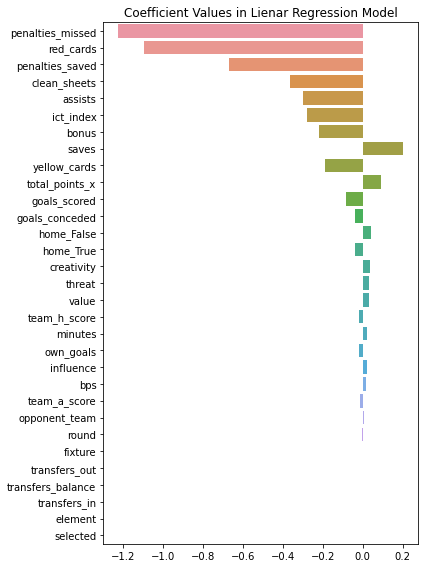

In [88]:
feature_importance = sorted(list(zip(lr.coef_, X_train.columns)), key=lambda x:abs(x[0]), reverse=True)
plt.figure(figsize=(6,8))
sns.barplot([x[0] for x in feature_importance], [x[1] for x in feature_importance])
plt.title('Coefficient Values in Lienar Regression Model')
plt.tight_layout()
plt.show()

## 4. Future Predictions
Let's see how the model performs for the latest week of the 2020/21 season:

In [104]:
week3 = pd.read_csv(r'C:\Users\vinhe\Code\Projects\fantasy-football-analysis\Fantasy-Premier-League-master\data\2020-21\gws\gw3.csv')
week4 = pd.read_csv(r'C:\Users\vinhe\Code\Projects\fantasy-football-analysis\Fantasy-Premier-League-master\data\2020-21\gws\gw4.csv')

In [106]:
week3_4 = pd.merge(week3, week4[['name', 'total_points']], on='name', how='inner')

# get home/away dummies
home_dummy = pd.get_dummies(week3_4['was_home'], prefix='home')
week3_4 = pd.concat([week3_4, home_dummy], axis=1).drop(['was_home', 'kickoff_time'], axis=1)

Now we will use the linear regression model to create a new column called "predicted points".
Next we will create a simple column that checks if the model over/undervalued the observation.

In [109]:
week3_4['predicted points'] = lr.predict(week3_4[X_train.columns])

# add a column for over/undervalued
week3_4['Model Value'] = ['overvalued' if pred > actual else 'undervalued' for (actual, pred) in
                         zip(week3_4['total_points_y'].values, week3_4['predicted points'].values)]

Now we will output the same performance metrics:

In [110]:
mse_unseen = mean_squared_error(week3_4['total_points_y'].values, week3_4['predicted points'].values) 
mae_unseen = mean_absolute_error(week3_4['total_points_y'].values, week3_4['predicted points'].values)  
mse_base2 = mean_squared_error(week3_4['total_points_y'].values, week3_4['total_points_x'].values) 
mae_base2 = mean_absolute_error(week3_4['total_points_y'].values, week3_4['total_points_x'].values)

print("Model Performance \n-----")
print(f"MSE for Week 4 Predictions: \t{round(mse_unseen,3)}") 
print(f"MAE for Week 4 Predictions: \t{round(mae_unseen,3)}") 
print("\nBaseline Performance \n-----")
print(f"MSE for Week 4 Predictions: \t{round(mse_base2,3)}") 
print(f"MAE for Week 4 Predictions: \t{round(mae_base2,3)}")

Model Performance 
-----
MSE for Week 4 Predictions: 	7.945
MAE for Week 4 Predictions: 	1.496

Baseline Performance 
-----
MSE for Week 4 Predictions: 	11.415
MAE for Week 4 Predictions: 	1.567


The model does not perform as well on the new unseen data but it does predict better than the simple baseline of predicting week 3's points for week 4.

Now let's visualise the predictions:

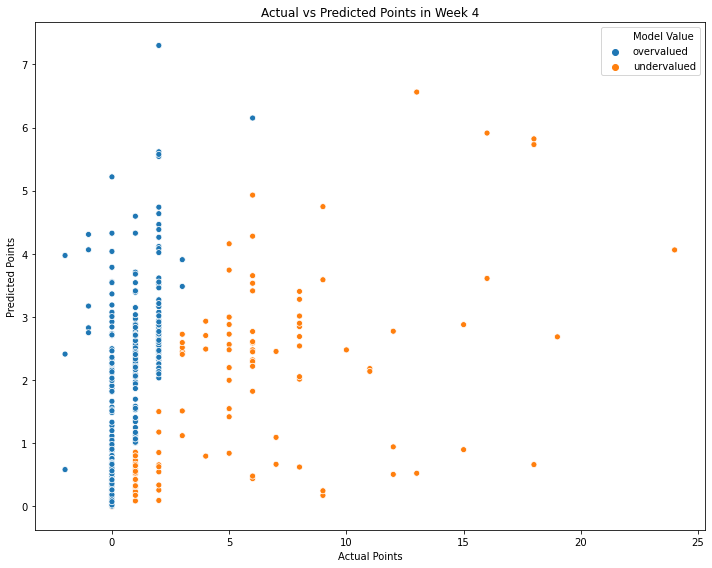

In [112]:
plt.figure(figsize=(10,8))
sns.scatterplot(week3_4['total_points_y'], week3_4['predicted points'], hue=week3_4['Model Value'])    
plt.xlabel('Actual Points') 
plt.ylabel('Predicted Points') 
plt.title('Actual vs Predicted Points in Week 4') 
plt.tight_layout() 